In [1]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, PoissonRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Funzione per valutare e plottare
# def evaluate_model(name, model, X_train, y_train, X_val, y_val, results):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_val)
# 
#     mae = mean_absolute_error(y_val, y_pred)
#     mse = mean_squared_error(y_val, y_pred)
#     r2 = r2_score(y_val, y_pred)
# 
#     print(f"{name}:\n  MAE: {mae:.2f}  MSE: {mse:.2f}  R²: {r2:.2f}")
# 
#     results.append({
#         'Model': name,
#         'MAE': mae,
#         'MSE': mse,
#         'R2': r2
#     })
# 
#     # Plot pred vs true
#     plt.figure()
#     plt.scatter(y_val, y_pred, alpha=0.6)
#     plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
#     plt.xlabel("True Count")
#     plt.ylabel("Predicted Count")
#     plt.title(f"{name} - Pred vs True")
#     plt.grid(True)
#     plt.show()

# Funzione principale da integrare dopo estrazione feature
# def train_all_regressors(X_train, y_train, X_val, y_val):
#     results = []
# 
#     regressors = {
#         'Linear Regression': LinearRegression(),
#         'Ridge Regression': Ridge(alpha=1.0),
#         'Lasso Regression': Lasso(alpha=0.1),
#         'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
#         'SVR (RBF Kernel)': SVR(kernel='rbf', C=1.0, epsilon=0.2),
#         'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
#         'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
#         'MLP Regressor': MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42),
#         'Poisson Regressor': PoissonRegressor(alpha=1.0, max_iter=1000)
#     }
# 
#     for name, model in regressors.items():
#         try:
#             evaluate_model(name, model, X_train, y_train, X_val, y_val, results)
#         except Exception as e:
#             print(f"Errore con {name}: {e}")
# 
#     return results


import os
import json
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, PoissonRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd

# === Dataset COCO Custom per Regression ===
class CocoCountDataset(Dataset):
    def __init__(self, img_dir, ann_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        with open(ann_file, 'r') as f:
            data = json.load(f)
        self.images = data['images']
        self.annotations = data['annotations']
        self.image_id_to_path = {img['id']: img['file_name'] for img in self.images}
        self.counts = self._compute_counts()

    def _compute_counts(self):
        counts = {}
        for ann in self.annotations:
            img_id = ann['image_id']
            counts[img_id] = counts.get(img_id, 0) + 1
        return counts

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_id = self.images[idx]['id']
        img_path = os.path.join(self.img_dir, self.image_id_to_path[img_id])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        count = self.counts.get(img_id, 0)
        return image, count

# === Feature extractor con ResNet50 (senza FC) ===
def extract_features(model, dataloader, device):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for imgs, counts in tqdm(dataloader, desc="Extracting features"):
            imgs = imgs.to(device)
            feats = model(imgs).cpu().numpy()
            features.extend(feats)
            labels.extend(counts.numpy())
    return np.array(features), np.array(labels)

# === Training pipeline per vari modelli ===
def run_pipeline(train_img_dir, train_ann, val_img_dir, val_ann, test_img_dir, test_ann):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Carica i dataset
    train_dataset = CocoCountDataset(train_img_dir, train_ann, transform)
    val_dataset = CocoCountDataset(val_img_dir, val_ann, transform)
    test_dataset = CocoCountDataset(test_img_dir, test_ann, transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Carica ResNet50
    resnet = models.resnet50(pretrained=True)
    resnet.fc = nn.Identity()  # Rimuove il layer fully connected
    resnet.to(device)

    # Estrai le feature
    X_train, y_train = extract_features(resnet, train_loader, device)
    X_val, y_val = extract_features(resnet, val_loader, device)
    X_test, y_test = extract_features(resnet, test_loader, device)

    # Lista dei regressori da provare
    regressors = {
        #'Linear Regression': LinearRegression(),
        #'Ridge Regression': Ridge(alpha=1.0),
        #'Lasso Regression': Lasso(alpha=0.1),
        #'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        #'SVR (RBF Kernel)': SVR(kernel='rbf', C=1.0, epsilon=0.2),
        #'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        #'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
        'MLP Regressor': MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42),
        'Poisson Regressor': PoissonRegressor(alpha=1.0, max_iter=1000)
    }

    # Funzione per valutare e plottare
    def evaluate_model(name, model, X_train, y_train, X_val, y_val, results):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        print(f"{name}:\n  MAE: {mae:.2f}  MSE: {mse:.2f}  R²: {r2:.2f}")

        results.append({
            'Model': name,
            'MAE': mae,
            'MSE': mse,
            'R2': r2
        })

        # Plot pred vs true
        plt.figure()
        plt.scatter(y_val, y_pred, alpha=0.6)
        plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
        plt.xlabel("True Count")
        plt.ylabel("Predicted Count")
        plt.title(f"{name} - Pred vs True")
        plt.grid(True)
        plt.show()
        print("Data e ora:", datetime.now().strftime("%d-%m-%Y %H:%M:%S"))

    # Risultati per tutti i modelli
    results = []

    # Esegui la valutazione per ogni modello
    for name, model in regressors.items():
        try:
            print("Validation")
            evaluate_model(name, model, X_train, y_train, X_val, y_val, results)
            print("Test")
            evaluate_model(name, model, X_train, y_train, X_test, y_test, results)
        except Exception as e:
            print(f"Errore con {name}: {e}")

    # Salva i risultati in un CSV
    pd.DataFrame(results).to_csv(f"{train_img_dir}regression_results.csv", index=False)


C:\Users\conca\Documents\progetti\vehicle_detection\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\conca\Documents\progetti\vehicle_detection\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|██████████| 60/60 [00:14<00:00,  4.21it/s]


Validation
Linear Regression:
  MAE: 18.56  MSE: 757.65  R²: 0.28


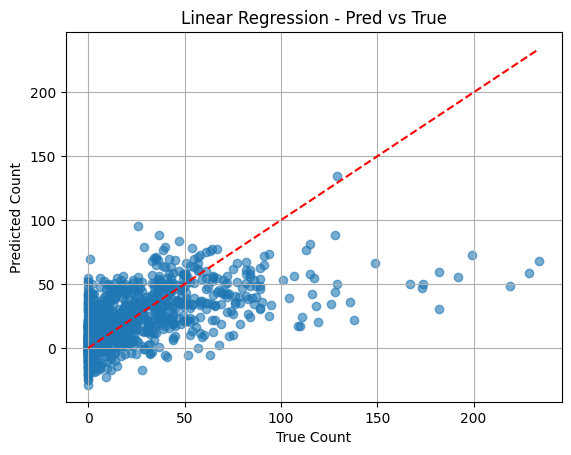

Test
Linear Regression:
  MAE: 18.67  MSE: 735.84  R²: 0.40


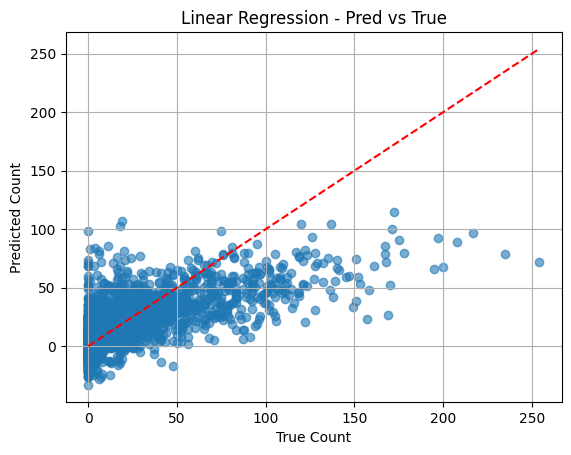

Validation
Ridge Regression:
  MAE: 18.20  MSE: 743.13  R²: 0.29


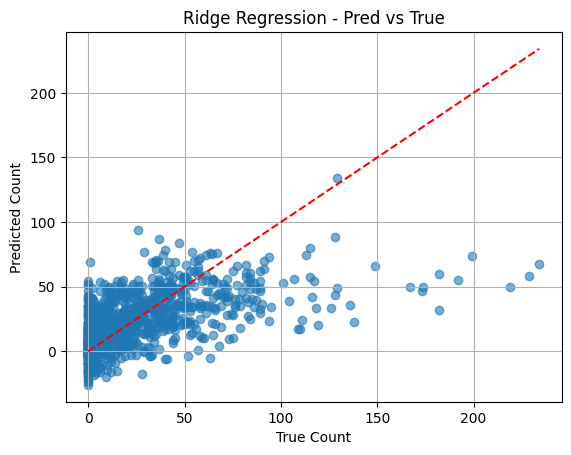

Test
Ridge Regression:
  MAE: 18.38  MSE: 725.74  R²: 0.41


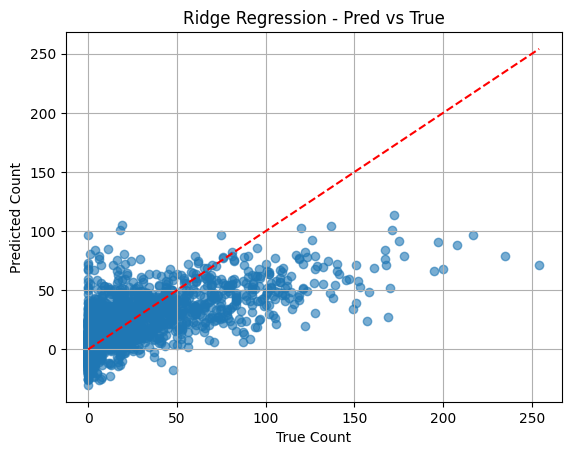

Validation
Lasso Regression:
  MAE: 14.84  MSE: 648.86  R²: 0.38


C:\Users\conca\Documents\progetti\vehicle_detection\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.279e+03, tolerance: 4.717e+02
  model = cd_fast.enet_coordinate_descent(


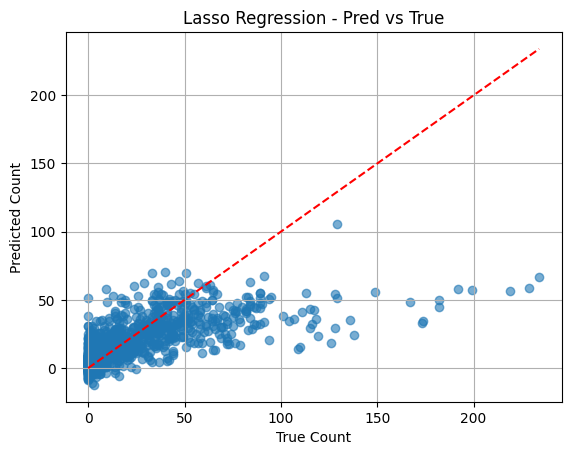

Test
Lasso Regression:
  MAE: 17.28  MSE: 790.62  R²: 0.35


C:\Users\conca\Documents\progetti\vehicle_detection\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.279e+03, tolerance: 4.717e+02
  model = cd_fast.enet_coordinate_descent(


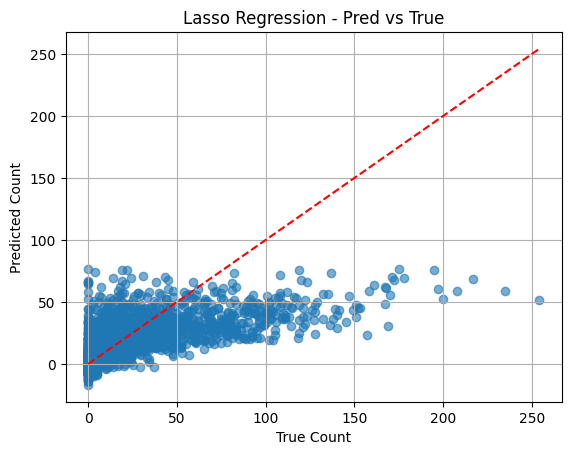

Validation
ElasticNet:
  MAE: 14.74  MSE: 650.69  R²: 0.38


C:\Users\conca\Documents\progetti\vehicle_detection\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.779e+04, tolerance: 4.717e+02
  model = cd_fast.enet_coordinate_descent(


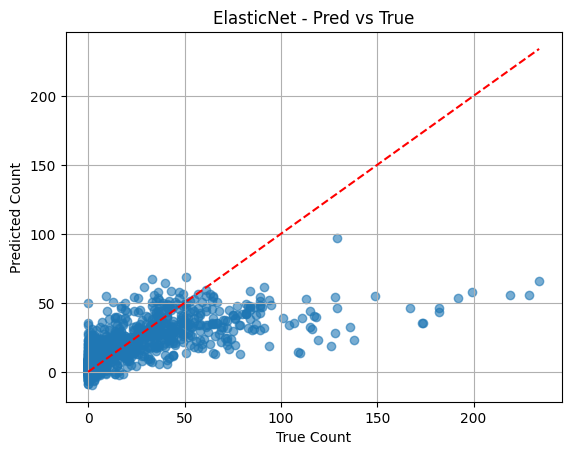

Test
ElasticNet:
  MAE: 17.05  MSE: 789.60  R²: 0.36


C:\Users\conca\Documents\progetti\vehicle_detection\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.779e+04, tolerance: 4.717e+02
  model = cd_fast.enet_coordinate_descent(


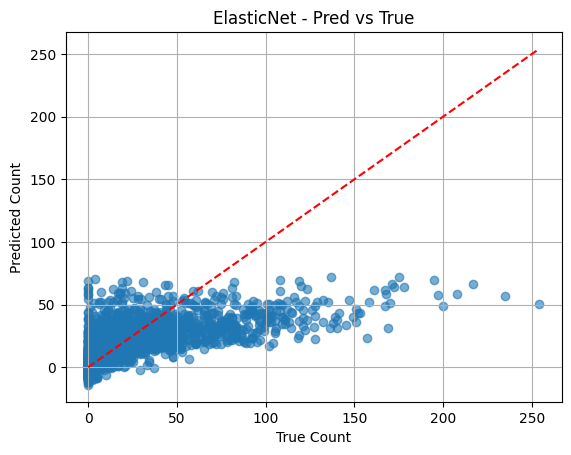

Validation
SVR (RBF Kernel):
  MAE: 17.84  MSE: 1049.49  R²: -0.00


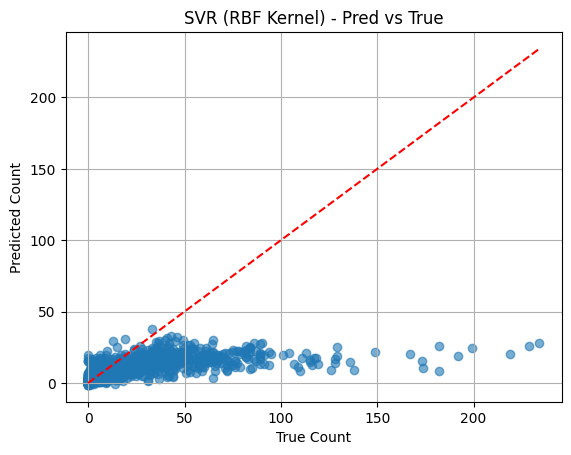

Test
SVR (RBF Kernel):
  MAE: 18.19  MSE: 1161.18  R²: 0.05


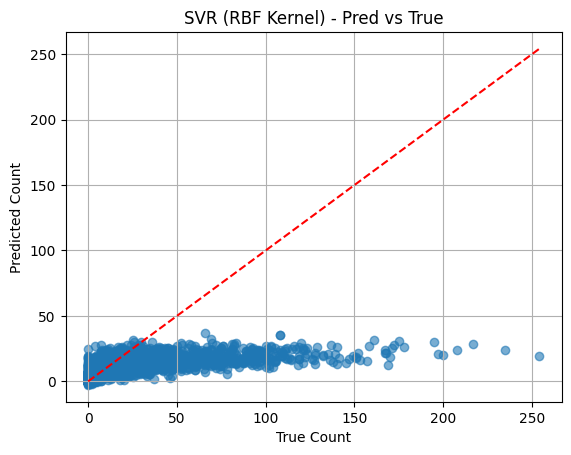

Validation
Random Forest:
  MAE: 15.90  MSE: 803.03  R²: 0.23


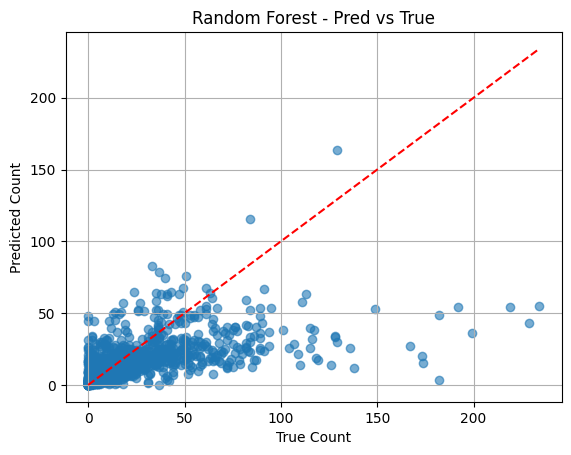

Test
Random Forest:
  MAE: 17.04  MSE: 902.27  R²: 0.26


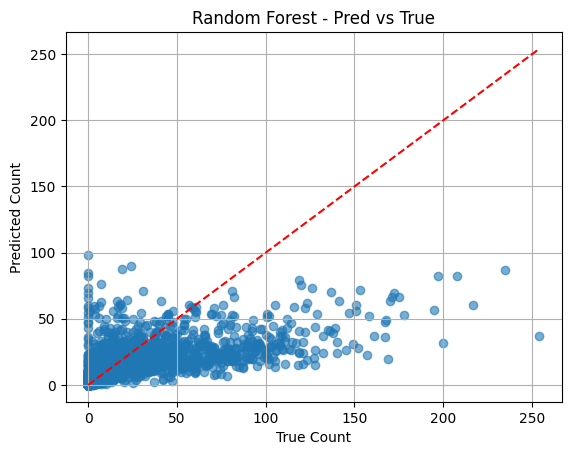

Validation
Gradient Boosting:
  MAE: 15.39  MSE: 739.74  R²: 0.29


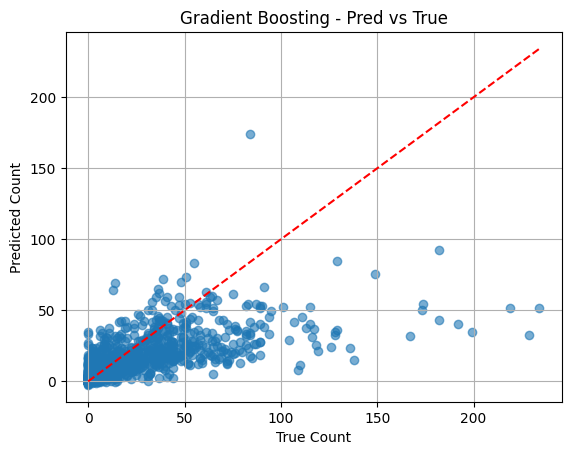

Test
Gradient Boosting:
  MAE: 17.03  MSE: 880.38  R²: 0.28


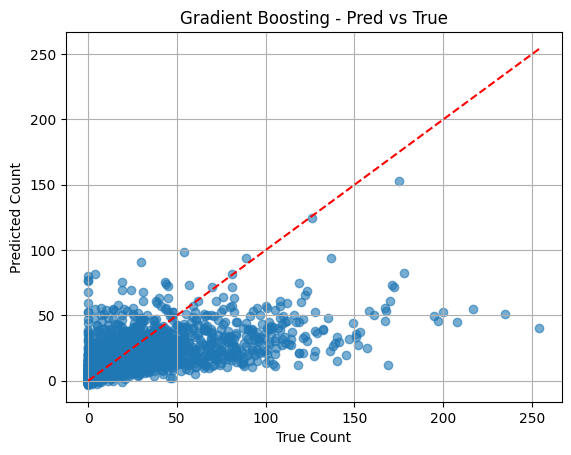

Validation
MLP Regressor:
  MAE: 17.13  MSE: 855.25  R²: 0.18


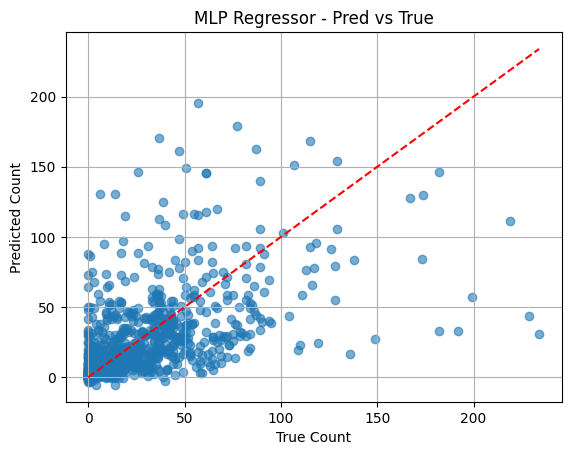

Test
MLP Regressor:
  MAE: 15.37  MSE: 756.16  R²: 0.38


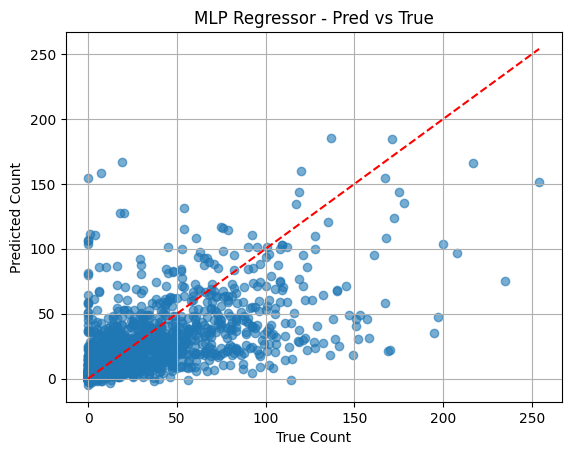

Validation
Poisson Regressor:
  MAE: 14.11  MSE: 663.66  R²: 0.37


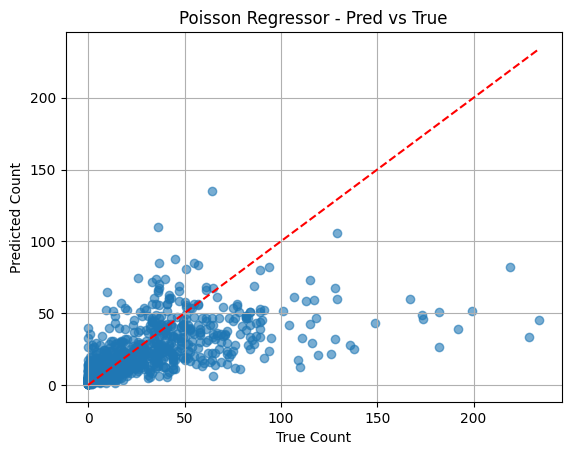

Test
Poisson Regressor:
  MAE: 14.45  MSE: 671.94  R²: 0.45


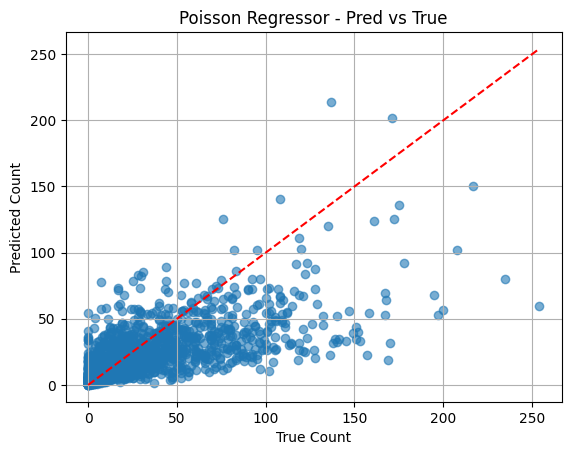

In [2]:
# === Esempio di esecuzione ===
nome_cartella = "EAGLE"
run_pipeline(
    train_img_dir=  f'{nome_cartella}/train/',
    train_ann=      f'{nome_cartella}/train/_annotations.coco.json',
    val_img_dir=    f'{nome_cartella}/valid/',
    val_ann=        f'{nome_cartella}/valid/_annotations.coco.json',
    test_img_dir=   f'{nome_cartella}/test/',
    test_ann=       f'{nome_cartella}/test/_annotations.coco.json'
)

C:\Users\conca\Documents\progetti\vehicle_detection\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\conca\Documents\progetti\vehicle_detection\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|██████████| 579/579 [02:07<00:00,  4.54it/s]


Validation
MLP Regressor:
  MAE: 2.23  MSE: 9.46  R²: 0.60


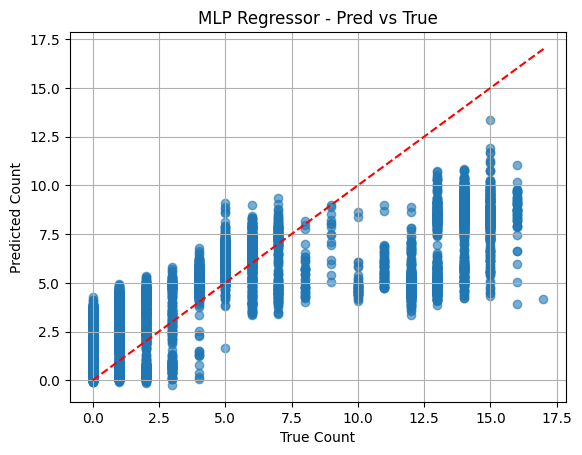

Data e ora: 22-06-2025 22:24:03
Test
MLP Regressor:
  MAE: 1.21  MSE: 3.05  R²: 0.35


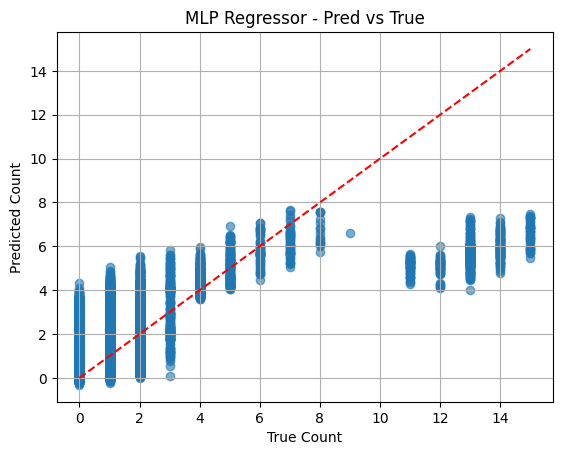

Data e ora: 22-06-2025 22:28:20
Validation
Poisson Regressor:
  MAE: 2.76  MSE: 21.51  R²: 0.10


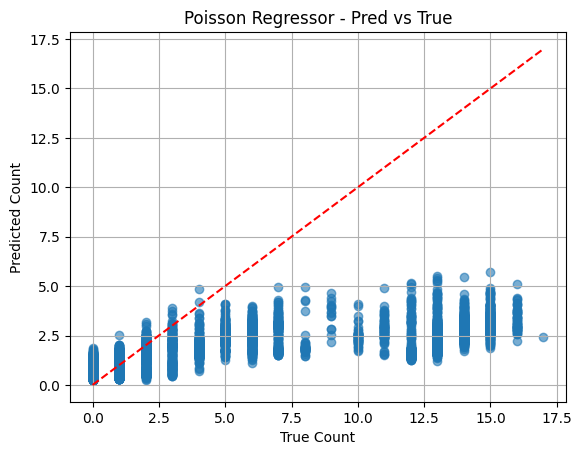

Data e ora: 22-06-2025 22:34:53
Test
Poisson Regressor:
  MAE: 0.98  MSE: 3.73  R²: 0.21


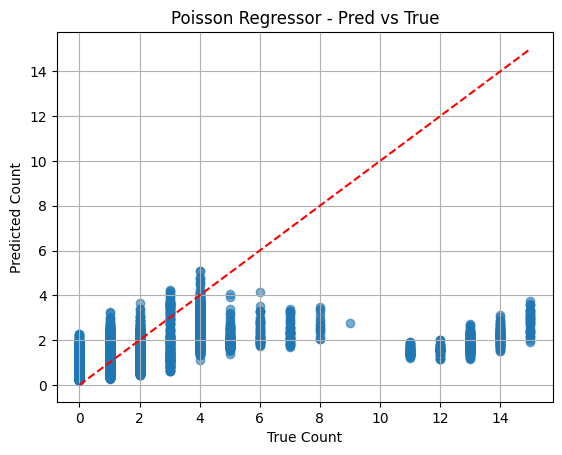

Data e ora: 22-06-2025 22:41:18


In [2]:
# === Esempio di esecuzione ===
nome_cartella = "RAIVD"
run_pipeline(
    train_img_dir=  f'{nome_cartella}/train/images/',
    train_ann=      f'{nome_cartella}/train/_annotations.coco.json',
    val_img_dir=    f'{nome_cartella}/valid/images/',
    val_ann=        f'{nome_cartella}/valid/_annotations.coco.json',
    test_img_dir=   f'{nome_cartella}/test/images/',
    test_ann=       f'{nome_cartella}/test/_annotations.coco.json'
)

Extracting features: 100%|██████████| 154/154 [00:30<00:00,  5.06it/s]


Validation
Linear Regression:
  MAE: 22.59  MSE: 2192.19  R²: 0.24


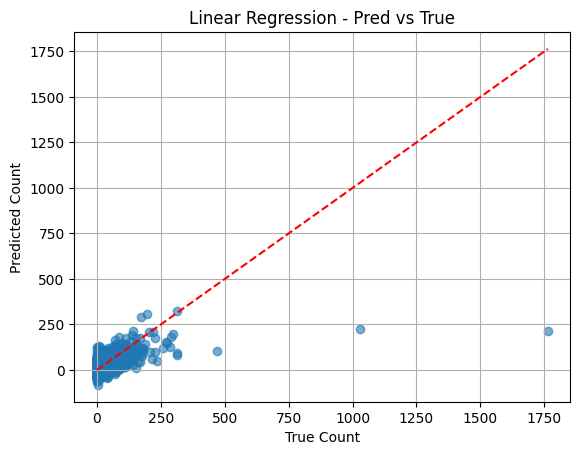

Data e ora: 22-06-2025 20:50:27
Test
Linear Regression:
  MAE: 23.66  MSE: 1740.18  R²: 0.55


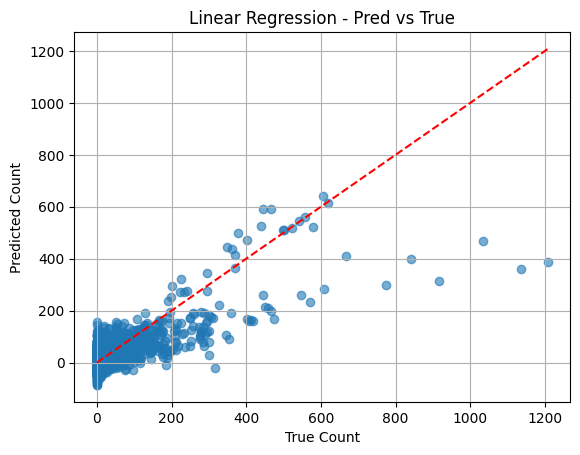

Data e ora: 22-06-2025 20:50:29
Validation
Ridge Regression:
  MAE: 22.48  MSE: 2188.30  R²: 0.24


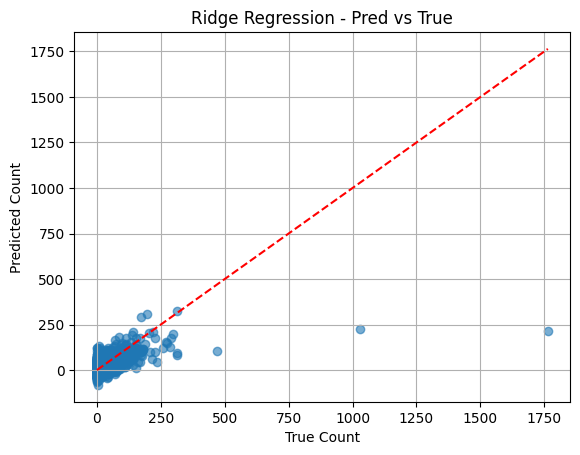

Data e ora: 22-06-2025 20:50:30
Test
Ridge Regression:
  MAE: 23.53  MSE: 1733.89  R²: 0.55


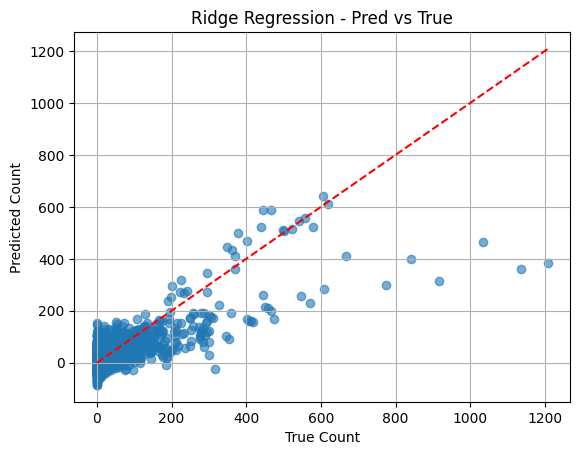

Data e ora: 22-06-2025 20:50:30
Validation
Lasso Regression:
  MAE: 19.85  MSE: 2259.06  R²: 0.22


C:\Users\conca\Documents\progetti\vehicle_detection\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+05, tolerance: 4.840e+03
  model = cd_fast.enet_coordinate_descent(


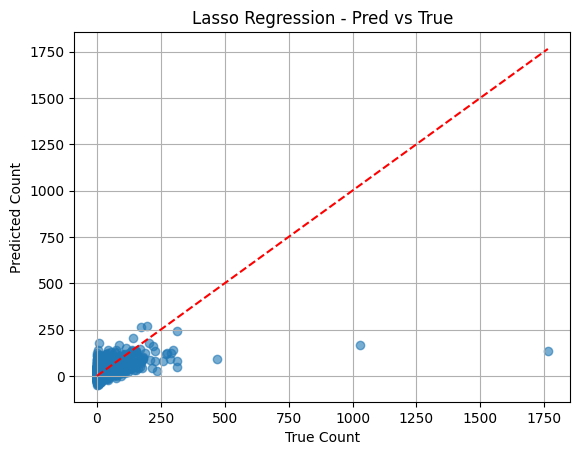

Data e ora: 22-06-2025 20:51:49
Test
Lasso Regression:
  MAE: 20.72  MSE: 1832.41  R²: 0.53


C:\Users\conca\Documents\progetti\vehicle_detection\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+05, tolerance: 4.840e+03
  model = cd_fast.enet_coordinate_descent(


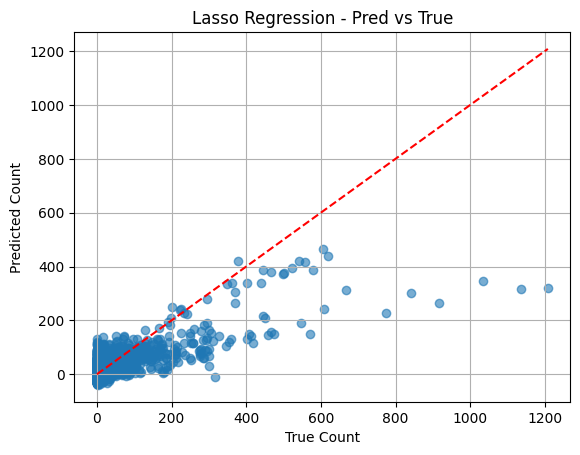

Data e ora: 22-06-2025 20:53:12
Validation


C:\Users\conca\Documents\progetti\vehicle_detection\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.471e+05, tolerance: 4.840e+03
  model = cd_fast.enet_coordinate_descent(


ElasticNet:
  MAE: 19.00  MSE: 2238.65  R²: 0.23


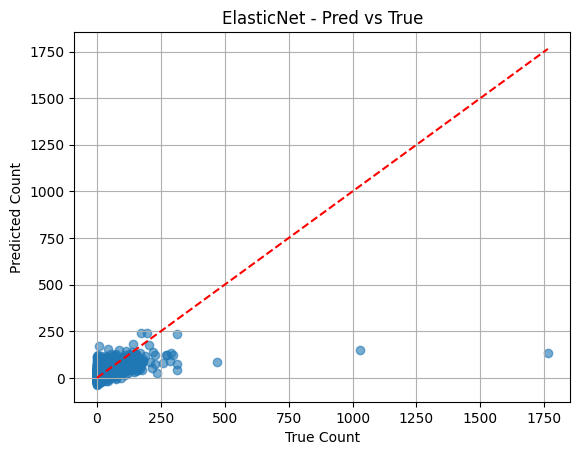

Data e ora: 22-06-2025 20:56:46
Test
ElasticNet:
  MAE: 20.32  MSE: 1969.33  R²: 0.49


C:\Users\conca\Documents\progetti\vehicle_detection\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.471e+05, tolerance: 4.840e+03
  model = cd_fast.enet_coordinate_descent(


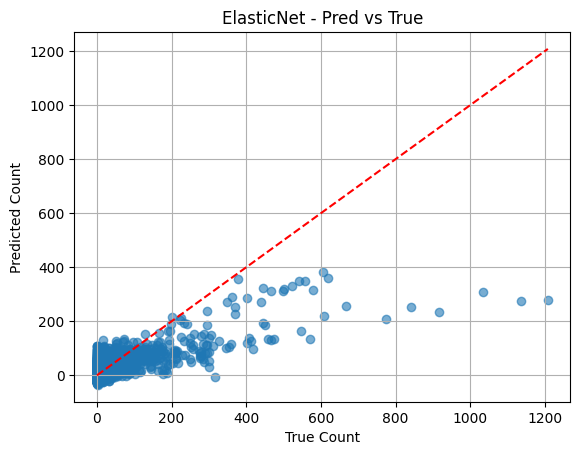

Data e ora: 22-06-2025 21:00:14
Validation
MLP Regressor:
  MAE: 14.72  MSE: 1910.59  R²: 0.34


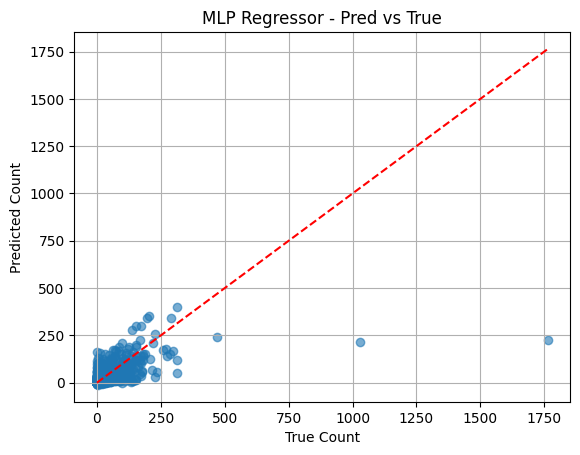

Data e ora: 22-06-2025 21:01:52
Test
MLP Regressor:
  MAE: 15.77  MSE: 1627.69  R²: 0.58


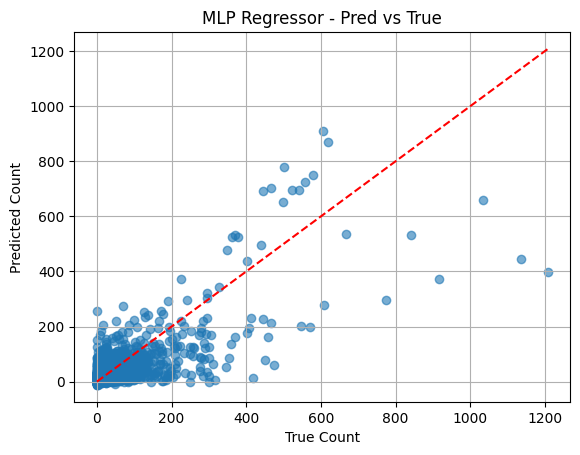

Data e ora: 22-06-2025 21:03:31
Validation
Poisson Regressor:
  MAE: 14.87  MSE: 2330.40  R²: 0.19


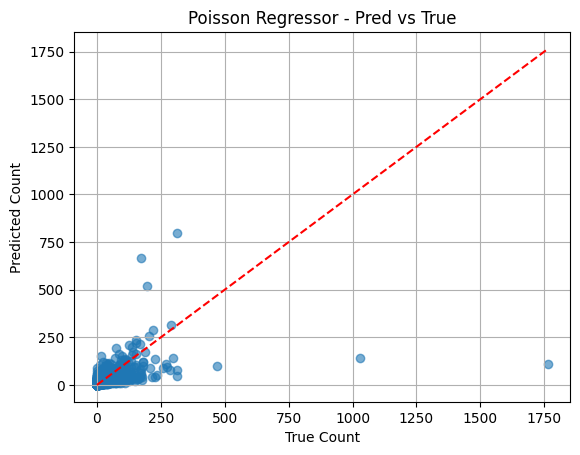

Data e ora: 22-06-2025 21:07:21
Test
Poisson Regressor:
  MAE: 16.18  MSE: 2172.09  R²: 0.44


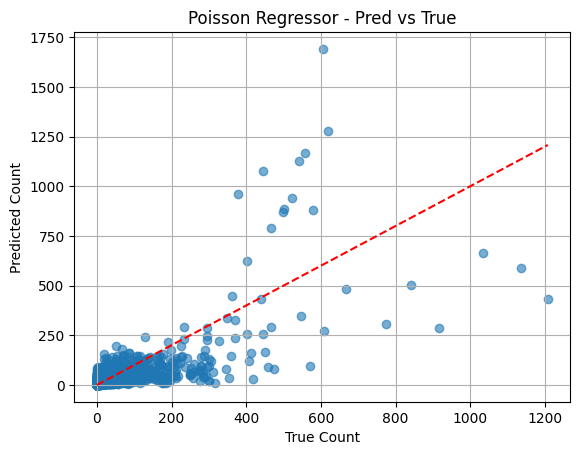

Data e ora: 22-06-2025 21:11:01


In [5]:
# === Esempio di esecuzione ===
nome_cartella = "SODA"
run_pipeline(
    train_img_dir=  f'{nome_cartella}/train/',
    train_ann=      f'{nome_cartella}/train/_annotations.coco.json',
    val_img_dir=    f'{nome_cartella}/valid/',
    val_ann=        f'{nome_cartella}/valid/_annotations.coco.json',
    test_img_dir=   f'{nome_cartella}/test/',
    test_ann=       f'{nome_cartella}/test/_annotations.coco.json'
)